# Introduction #

In the first two lessons, we learned how to build fully-connected networks out of stacks of dense layers. When first created, all of the network's weights are set randomly -- the network doesn't "know" anything yet. In this lesson we're going to see how to train a neural network; we're going to see how neural networks *learn*.

As with all machine learning tasks, we begin with a set of training data. Each example in the training data consists of some features (the inputs) together with an expected target (the output). Training the network means adjusting its weights in such a way that it can transform the features into the target. In the *80 Cereals* dataset, for instance, we want a network that can take each cereal's `'sugar'`, `'fiber'`, and `'protein'` content and produce a prediction for that cereal's `'calories'`. If we can successfully train a network to do that, its weights must represent in some way the relationship between those features and that target as expressed in the training data.

In addition to the training data, we need two more things:
- A "loss function" that measures how good the network's predictions are.
- An "optimizer" that can tell the network how to change its weights.

# The Loss Function #

We've seen how to design an architecture for a network, but we haven't seen how to tell a network *what* problem to solve. This is the job of the loss function.

The **loss function** measures the disparity between the the target's true value and the value the model predicts. 

Different problems call for different loss functions. We have been looking at **regression** problems, where the task is to predict some numerical value -- calories in *80 Cereals*, rating in *Red Wine Quality*. Other regression tasks might be predicting the price of a house or the fuel efficiency of a car.

A common loss function for regression problems is the **mean absolute error** or **MAE**. For each prediction `y_pred`, MAE measures the disparity from the true target `y_true` by an absolute difference `abs(y_true - y_pred)`.

The total MAE loss on a dataset is the mean of all these absolute differences.

<figure style="padding: 1em;">
<img src="https://i.imgur.com/VDcvkZN.png" width="500" alt="A graph depicting error bars from data points to the fitted line..">
<figcaption style="textalign: center; font-style: italic"><center>The mean absolute error is the average length between the fitted curve and the data points.
</center></figcaption>
</figure>

Besides MAE, other loss functions you might see for regression problems are the mean-squared error (MSE) or the Huber loss (both available in Keras).

During training, the model will use the loss function as a guide for finding the correct values of its weights (lower loss is better). In other words, the loss function tells the network its objective.

# The Optimizer - Stochastic Gradient Descent #

We've described the problem we want the network to solve, but now we need to say *how* to solve it. This is the job of the **optimizer**. The optimizer is an algorithm that adjusts the weights to minimize the loss.

Virtually all of the optimization algorithms used in deep learning belong to a family called **stochastic gradient descent**. They are iterative algorithms that train a network in steps. One **step** of training goes like this:
1. Sample some training data and run it through the network to make predictions.
2. Measure the loss between the predictions and the true values.
3. Finally, adjust the weights in a direction that makes the loss smaller.

Then just do this over and over until the loss is as small as you like (or until it won't decrease any further.)

<figure style="padding: 1em;">
<img src="https://i.imgur.com/rFI1tIk.gif" width="1600" alt="Fitting a line batch by batch. The loss decreases and the weights approach their true values.">
<figcaption style="textalign: center; font-style: italic"><center>Training a neural network with Stochastic Gradient Descent.
</center></figcaption>
</figure>

Each iteration's sample of training data is called a **minibatch** (or often just "batch"), while a complete round of the training data is called an **epoch**. The number of epochs you train for is how many times the network will see each training example.

The animation shows the linear model from Lesson 1 being trained with SGD. The pale red dots depict the entire training set, while the solid red dots are the minibatches. Every time SGD sees a new minibatch, it will shift the weights (`w` the slope and `b` the y-intercept) toward their correct values on that batch. Batch after batch, the line eventually converges to its best fit. You can see that the loss gets smaller as the weights get closer to their true values.

## Learning Rate and Batch Size ##

Notice that the line only makes a small shift in the direction of each batch (instead of moving all the way). The size of these shifts is determined by the **learning rate**. A smaller learning rate means the network needs to see more minibatches before its weights converge to their best values.

The learning rate and the size of the minibatches are the two parameters that have the largest effect on how the SGD training proceeds. Their interaction is often subtle and the right choice for these parameters isn't always obvious. (We'll explore these effects in the exercise.)

Fortunately, for most work it won't be necessary to do an extensive hyperparameter search to get satisfactory results. **Adam** is an SGD algorithm that has an adaptive learning rate that makes it suitable for most problems without any parameter tuning (it is "self tuning", in a sense). Adam is a great general-purpose optimizer.

## Adding the Loss and Optimizer ##

After defining a model, you can add a loss function and optimizer with the model's `compile` method:

```
model.compile(
    optimizer="adam",
    loss="mae",
)
```

Notice that we are able to specify the loss and optimizer with just a string. You can also access these directly through the Keras API -- if you wanted to tune parameters, for instance -- but for us, the defaults will work fine.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
    <strong>What's In a Name?</strong><br>
The <strong>gradient</strong> is a vector that tells us in what direction the weights need to go. More precisely, it tells us how to change the weights to make the loss change <em>fastest</em>. We call our process gradient <strong>descent</strong> because it uses the gradient to <em>descend</em> the loss curve towards a minimum. <strong>Stochastic</strong> means "determined by chance." Our training is <em>stochastic</em> because the minibatches are <em>random samples</em> from the dataset. And that's why it's called SGD!
</blockquote>

# Example - Red Wine Quality #

Now we know everything we need to start training deep learning models. So let's see it in action! We'll use the *Red Wine Quality* dataset.

This dataset consists of physiochemical measurements from about 1600 Portuguese red wines. Also included is a quality rating for each wine from blind taste-tests. How well can we predict a wine's perceived quality from these measurements?

We've put all of the data preparation into this next hidden cell. It's not essential to what follows so feel free to skip it. One thing you might note for now though is that we've rescaled each feature to lie in the interval $[0, 1]$. As we'll discuss more in Lesson 5, neural networks tend to perform best when their inputs are on a common scale.

In [2]:
import pandas as pd
from IPython.display import display

red_wine = pd.read_csv('Data/red-wine.csv')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)
display(df_train.head(4))

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1109,10.8,0.470,0.43,2.10,0.171,27.0,66.0,0.99820,3.17,0.76,10.8,6
1032,8.1,0.820,0.00,4.10,0.095,5.0,14.0,0.99854,3.36,0.53,9.6,5
1002,9.1,0.290,0.33,2.05,0.063,13.0,27.0,0.99516,3.26,0.84,11.7,7
487,10.2,0.645,0.36,1.80,0.053,5.0,14.0,0.99820,3.17,0.42,10.0,6


In [3]:
# Scale to [0, 1]
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

In [4]:
# Split features and target
X_train = df_train.drop('quality', axis=1)
X_valid = df_valid.drop('quality', axis=1)
y_train = df_train['quality']
y_valid = df_valid['quality']

How many inputs should this network have? We can discover this by looking at the number of columns in the data matrix. Be sure not to include the target (`'quality'`) here -- only the input features.

In [5]:
print(X_train.shape)

(1119, 11)


Eleven columns means eleven inputs.

We've chosen a three-layer network with over 1500 neurons. This network should be capable of learning fairly complex relationships in the data.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=[11]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(1),
])

Deciding the architecture of your model should be part of a process. Start simple and use the validation loss as your guide. You'll learn more about model development in the exercises.

After defining the model, we compile in the optimizer and loss function.

In [17]:
model.compile(
    optimizer='Adam',
    loss='mae',
)

Now we're ready to start the training! We've told Keras to feed the optimizer 256 rows of the training data at a time (the `batch_size`) and to do that 10 times all the way through the dataset (the `epochs`).

In [18]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=10,
)

Epoch 1/10
5/5 [==============================] - 0s 56ms/step - loss: 0.1260 - val_loss: 0.1007
Epoch 2/10
5/5 [==============================] - 0s 25ms/step - loss: 0.1162 - val_loss: 0.1019
Epoch 3/10
5/5 [==============================] - 0s 26ms/step - loss: 0.1105 - val_loss: 0.1096
Epoch 4/10
5/5 [==============================] - 0s 26ms/step - loss: 0.1055 - val_loss: 0.0986
Epoch 5/10
5/5 [==============================] - 0s 23ms/step - loss: 0.1020 - val_loss: 0.1076
Epoch 6/10
5/5 [==============================] - 0s 24ms/step - loss: 0.1017 - val_loss: 0.0984
Epoch 7/10
5/5 [==============================] - 0s 25ms/step - loss: 0.1000 - val_loss: 0.1017
Epoch 8/10
5/5 [==============================] - 0s 25ms/step - loss: 0.0973 - val_loss: 0.0991
Epoch 9/10
5/5 [==============================] - 0s 23ms/step - loss: 0.0962 - val_loss: 0.0977
Epoch 10/10
5/5 [==============================] - 0s 28ms/step - loss: 0.0959 - val_loss: 0.0997


You can see that Keras will keep you updated on the loss as the model trains.

Often, a better way to view the loss though is to plot it. The `fit` method in fact keeps a record of the loss produced during training in a `History` object. We'll convert the data to a Pandas dataframe, which makes the plotting easy.

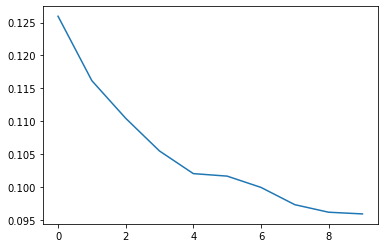

In [19]:
import pandas as pd

# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df['loss'].plot();

<AxesSubplot:>

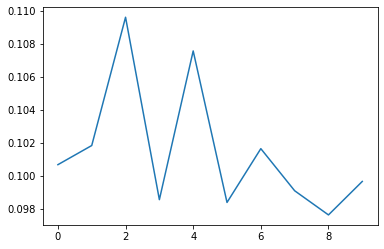

In [20]:
history_df['val_loss'].plot()

Notice how the loss levels off as the epochs go by. When the loss curve becomes horizontal like that, it means the model has learned all it can and there would be no reason continue for additional epochs.

# Your Turn #

Now, [**use stochastic gradient descent**](https://www.kaggle.com/kernels/fork/11887330) to train your network.

---




*Have questions or comments? Visit the [Learn Discussion forum](https://www.kaggle.com/learn-forum/191966) to chat with other Learners.*